In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import gensim
import chardet
import ast
import re
from gensim.parsing.preprocessing import remove_stopwords
import collections 
import itertools
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Activation, Dense

In [ ]:
reviews_train =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/train.csv")
reviews_test =  pd.read_csv(r"./drive/MyDrive/datasets/Computation-Intelligence/project2/test.csv")

# **PART 0 -- PREPROCESSING**

In [ ]:
reviews_train = reviews_train.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 3', 1)
reviews_test = reviews_test.drop('Unnamed: 4', 1)
'''removing rows with na values'''
reviews_train = reviews_train.dropna() #843 978 1755 1961 have values for "Unnamed: 3" 
reviews_test = reviews_test.dropna()

'''removing rows with no text for overview'''
reviews_train = reviews_train[reviews_train['overview'].str.contains('[A-Za-z]')]
reviews_test = reviews_test[reviews_test['overview'].str.contains('[A-Za-z]')]

In [ ]:
print(reviews_train.shape[0])
print(reviews_test.shape[0])

1994
996


In [ ]:
reviews_train.head()

,id,genres,overview
0,1,"[{'id': 35, 'name': 'Comedy'}]","When Lou, who has become the ""father of the In..."
1,2,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Mia Thermopolis is now a college graduate and ...
2,3,"[{'id': 18, 'name': 'Drama'}]","Under the direction of a ruthless instructor, ..."
3,4,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4,5,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",Marine Boy is the story of a former national s...


In [ ]:
'''MODIFYING GENRES FOR REVIEWS TEST'''

for index, row in reviews_train.iterrows():
  genres = ast.literal_eval(row['genres'])
  st = '' 
  for genre in genres:
    st += f"{genre['name']},"
  st = st[0:-1] 
  reviews_train.loc[index,'genres'] = st




'''MODIFYING GENRES FOR REVIEWS TRAIN'''

for index, row in reviews_test.iterrows():
  genres = ast.literal_eval(row['genres'])
  st = '' 
  for genre in genres:
    st += f"{genre['name']},"
  st = st[0:-1] 
  reviews_test.loc[index,'genres'] = st



In [ ]:
reviews_train.head()

,id,genres,overview
0,1,Comedy,"When Lou, who has become the ""father of the In..."
1,2,"Comedy,Drama,Family,Romance",Mia Thermopolis is now a college graduate and ...
2,3,Drama,"Under the direction of a ruthless instructor, ..."
3,4,"Thriller,Drama",Vidya Bagchi (Vidya Balan) arrives in Kolkata ...
4,5,"Action,Thriller",Marine Boy is the story of a former national s...


**Finding movie by genre popularity in dataset**

In [ ]:
genre_count = collections.Counter(itertools.chain.from_iterable(v.split(',') for v in reviews_train.genres))

genre_count_df = pd.DataFrame({'Genre': list(genre_count.keys()), 
                              'Count': list(genre_count.values())})

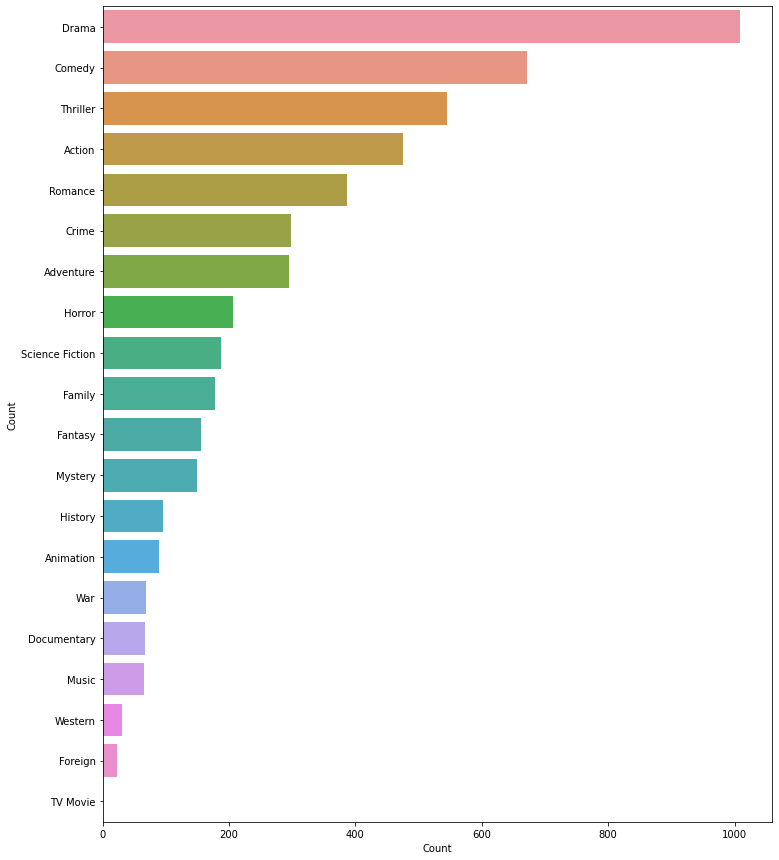

In [ ]:
g = genre_count_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [ ]:
y_train = reviews_train['genres'].str.get_dummies(sep=',')
y_test = reviews_test['genres'].str.get_dummies(sep=',')

# reviews_train_f = pd.concat([reviews_train, y_train], axis=1, join='inner')
# reviews_test_f = pd.concat([reviews_test, y_test], axis=1, join='inner')

# reviews_train_f = reviews_train_f.drop(['genres'],axis=1)
# reviews_test_f = reviews_test_f.drop(['genres'],axis=1)
y_train.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
y_train_vec = y_train.values
y_test_vec = y_test.values

In [ ]:
y_train_vec.shape

(1994, 20)

in this section, we will clean up the overview part of the input of our problem

In [ ]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

# def remove_stopwords(text):
#     no_stopword_text = [w for w in text.split() if not w in stop_words]
#     return ' '.join(no_stopword_text)


def final_clean(text):
      return gensim.utils.simple_preprocess (text)


In [ ]:
x_train = reviews_train['overview']
x_test = reviews_test['overview']

x_train = x_train.apply(lambda x: clean_text(x))
x_test = x_test.apply(lambda x: clean_text(x))

x_train = x_train.apply(remove_stopwords)
x_test = x_test.apply(remove_stopwords)

x_train = x_train.apply(lambda x: final_clean(x))
x_test = x_test.apply(lambda x: final_clean(x))

In [ ]:
x_train[0]

['lou',
 'father',
 'internet',
 'shot',
 'unknown',
 'assailant',
 'jacob',
 'nick',
 'time',
 'machine',
 'save',
 'friend']

In [1]:
SIZE = 150
WINDOW = 5

In [ ]:
w2v_model_trn = gensim.models.Word2Vec (x_train, size=SIZE, window=WINDOW, min_count=2, workers=10)
w2v_model_trn.train(x_train,total_examples=len(x_train),epochs=10)

w2v_model_tst = gensim.models.Word2Vec (x_test, size=SIZE, window=WINDOW, min_count=2, workers=10)
w2v_model_tst.train(x_test,total_examples=len(x_test),epochs=10)

(222593, 278170)

In [ ]:
w1 = "death"
w2v_model_trn.wv.most_similar (positive=w1)

[('money', 0.999982476234436),
 ('evil', 0.9999806880950928),
 ('night', 0.9999804496765137),
 ('planet', 0.9999796152114868),
 ('local', 0.9999794960021973),
 ('john', 0.9999793767929077),
 ('past', 0.9999793767929077),
 ('search', 0.9999792575836182),
 ('known', 0.9999791383743286),
 ('prison', 0.9999790787696838)]

In [ ]:
#(w2v_model_trn['father'] + w2v_model_trn['car'])/2

In [ ]:
x_train_vec = np.zeros((len(x_train), SIZE))

for idx, paragraph in enumerate(x_train): 
  ln = len(paragraph)
  arr = np.zeros(SIZE)
  for word in paragraph:
    try:
      arr = w2v_model_trn[word] + arr
  
    except KeyError:
      ln -= 1
  arr = arr/ln 
  # if idx == 156:
  #   print(f"{arr} --- len:{ln}\n\n\n\n")
  x_train_vec[idx,:] = arr
  # print(x_train_vec[idx,:])  
  # print(idx)
  # break




x_test_vec = np.zeros((len(x_test), SIZE))

for idx, paragraph in enumerate(x_test): 
  ln = len(paragraph)
  arr = np.zeros(SIZE)
  for word in paragraph:
    try:
      arr = w2v_model_tst[word] + arr
      #print(f"{arr}\n\n\n\n")
    except KeyError:
      ln -= 1
  arr = arr/ln 
  x_test_vec[idx,:] = arr


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
print(x_train_vec.shape)

print(y_train_vec.shape)

(1994, 500)
(1994, 20)


Training the model

In [ ]:

'''METHOD 1: LR'''
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(x_train_vec, y_train)
'''METHOD 2 : NN'''

# def get_model(n_inputs, n_outputs):
# 	model = Sequential()
# 	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
# 	model.add(Dense(n_outputs, activation='sigmoid'))
# 	model.compile(loss='binary_crossentropy', optimizer='adam')
# 	return model
 

# X, y = x_train_vec, y_train_vec
# n_inputs, n_outputs = X.shape[1], y.shape[1]

# model = get_model(n_inputs, n_outputs)

# model.fit(X, y, verbose=0, epochs=100)

# yhat = model.predict(X)[0]
# print(yhat)


#np.argmax(model.predict(asarray([X[30]])))

'METHOD 2 : NN'

In [ ]:
nm = 656
print(clf.predict(x_train_vec)[nm])
print(y_train_vec[nm])
# mdl.predict(x_train_vec)[1992]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


In [ ]:
#x_train_vec[np.isnan(x_train_vec)] = 0
#np.argwhere(np.isnan(x_train_vec))
#print(x_train_vec[0,:])

In [ ]:
print(y_train_vec[0]) 

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(clf.predict(x_train_vec)[234])
print(y_train_vec[234])

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


# **PART 1 -- WORD2VEC**

In [ ]:
revs = reviews_train["overview"].to_numpy()

'Taking all that was great from the first installment, ABCs OF DEATH 2 aims to be a wilder, leaner, faster paced and even more entertaining anthology this time around, with a new crop of award-winning, visionary filmmakers from around the globe.'

# **PART 2 -- BAG OF WORDS**

# **PART 2.5 -- RESULTS OF THE PREVIOUS PARTS (WORD2VEC VS BOW)**